In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-06-22 14:25:16,264 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:16,266 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:16,267 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 14:25:16,268 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:16,269 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:16,270 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 14:25:16,275 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/de

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-06-22 14:25:17,025 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 14:25:17,089 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:17,090 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:17,091 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 14:25:17,093 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 14:25:17,813 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 14:25:17,873 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:17,875 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:17,876 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 14:25:17,877 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:17,878 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:17,879 - settings - Setting database.pa

In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-06-22 14:25:18,803 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 14:25:18,806 - settings - Setting database.user to celiib
INFO - 2021-06-22 14:25:18,807 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 14:25:18,809 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 14:25:19,596 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

In [144]:
(jobs_table & "key_hash = '0743c66ad7741e6b6fdcf2591b23eacc'").fetch1('key')

{'ver': Decimal('88.00'),
 'nucleus_id': 558684,
 'segment_id': 864691136378859477,
 'old_ver': Decimal('0.08')}

In [145]:
minnie.AutoProofreadValidationSegmentMap4 & "segment_id=864691136378859477"

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,558684,864691136378859477,0.08,864691136008425132,True,True,full,1,0,0,0,merge with long myelinated axon


In [140]:
jobs_table = schema.jobs & "table_name = '__auto_proofread_validation_score6'"
error_job = (jobs_table & "key_hash = '9e77fcc57380988689907f4df10f18e4'")
print(error_job.fetch1("error_stack"))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/datajoint/autopopulate.py", line 159, in populate
    make(dict(key))
  File "Run_8_AutoProofreadValidationScore6.py", line 285, in make
    split_index=split_index)
  File "/meshAfterParty/validation_utils.py", line 2394, in filtered_neuron_score
    soma_center = neuron_obj[neuron_obj.get_soma_node_names()[0]].mesh_center)
  File "/meshAfterParty/validation_utils.py", line 1089, in synapse_validation_df_single_neuron
    ext_df = extension_synapse_dict(segment_id=new_segment_id)
  File "/meshAfterParty/validation_utils.py", line 1350, in extension_synapse_dict
    curr_table["synapse_x"] = syn_coordinates[:,0]
TypeError: list indices must be integers or slices, not tuple



In [141]:
error_job.delete()

# Look at certain neuron after processing

In [118]:
segment_id = 864691135584074360
curr_table = (minnie.AutoProofreadValidationScore6() & dict(segment_id=segment_id))
decomp_path,validation_df = curr_table.fetch1("decomposition","validation_df")
neuron_obj = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [119]:
nviz.visualize_neuron(neuron_obj,
                     limb_branch_dict="all")

Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh

 Working on visualization type: skeleton
No Synapses to plot


In [121]:
return_validation_df_revised = vu.load_df_val_from_numpy(validation_df)
filt_neuron = neuron_obj
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.05,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

Using the mesh from the neuron object


TP:yellow
TN:aqua
FP:black
FN:orange


# Getting all of the scores

In [136]:
minnie.AutoProofreadValidationScore6()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,369.84999619148164,=BLOB=,=BLOB=,7,160,11,0,0.3888888888888889,1.0,0.56,5281,7,39,3,0.9926691729323308,0.9994322482967449,0.9960392304790645,435.59
88.00,223037,864691136227167569,0.08,0,=BLOB=,63.375728490237755,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3410,3859,0,0.00025906735751295336,1.0,0.000518000518000518,512.22
88.00,225498,864691135753932237,0.08,0,=BLOB=,185.8554437449504,=BLOB=,=BLOB=,6,77,0,5,1.0,0.5454545454545454,0.7058823529411764,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,103.53
88.00,230236,864691135609687047,0.08,0,=BLOB=,1400.0527722290963,=BLOB=,=BLOB=,31,552,9,19,0.775,0.62,0.6888888888888889,1961,22,1,1,0.9994903160040775,0.9994903160040775,0.9994903160040775,396.06
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,975,0,5,nan,0.0,nan,2750,2329,7,48,0.9974610083424011,0.9828448892065761,0.99009900990099,507.11
88.00,258307,864691135293126156,0.08,0,=BLOB=,1095.334412475715,=BLOB=,=BLOB=,43,335,17,27,0.7166666666666667,0.6142857142857143,0.6615384615384615,2984,7,25,19,0.9916915918909937,0.9936729936729937,0.9926813040585496,382.22
88.00,262773,864691136023889209,0.08,0,=BLOB=,183.47810007157142,=BLOB=,=BLOB=,9,48,2,0,0.8181818181818182,1.0,0.9,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,95.45
88.00,264870,864691136951664863,0.08,0,=BLOB=,1031.1101255879166,=BLOB=,=BLOB=,31,421,3,1,0.9117647058823529,0.96875,0.9393939393939394,2008,25,4,33,0.9980119284294234,0.9838314551690348,0.9908709597828769,419.38
88.00,269247,864691135584074360,0.08,0,=BLOB=,1743.8423406603513,=BLOB=,=BLOB=,163,111,0,10,1.0,0.9421965317919075,0.9702380952380953,807,0,7,64,0.9914004914004914,0.9265212399540758,0.9578635014836795,271.88
88.00,271518,864691136108768952,0.08,0,=BLOB=,319.36652534606304,=BLOB=,=BLOB=,7,43,1,0,0.875,1.0,0.9333333333333333,2030,0,4,1,0.9980334316617503,0.999507631708518,0.9987699876998771,136.33


In [133]:
minnie,_ = du.configure_minnie_vm()
validation_dfs = minnie.AutoProofreadValidationScore6().fetch("validation_df")
validation_dfs = [vu.load_df_val_from_numpy(k) for k in validation_dfs]
validation_dfs

[     synapse_id synapse_type auto_valid synapse_x synapse_y synapse_z  \
 0      76963424       presyn       True    521800    532392    972400   
 1      76963829       presyn       True    523416    531720    972240   
 2      76964110       presyn       True    524512    532600    972680   
 3      78899369       presyn       True    534080    501888    975520   
 4      78899421       presyn       True    534352    501976    975760   
 ...         ...          ...        ...       ...       ...       ...   
 5503  117704562      postsyn      False    612136    502816   1005040   
 5504  117704639      postsyn      False    612600    502936   1005600   
 5505  117704984      postsyn      False    614240    498816   1006840   
 5506  121682236      postsyn      False    622088    517176   1012840   
 5507  137292646      postsyn      False    659096    515676    926400   
 
      manual_valid category      old_segment_id      new_segment_id  \
 0            True       TP  8646911355

Segment Id = 864691134988385914
Postsyn counts:
TP:424933
TN:78379
FP:6356
FN:7400
Presyn counts:
TP:1486
TN:18492
FP:366
FN:773


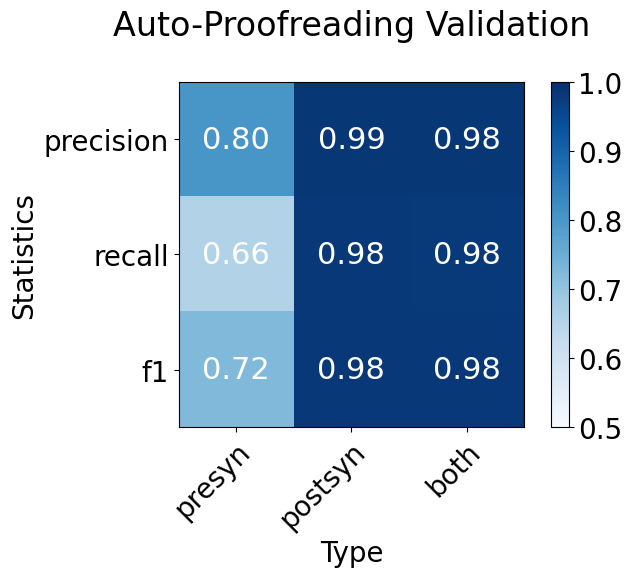

In [134]:
import pandas_utils as pu
total_validation_df = pu.concat(validation_dfs)
total_validation_df
vu.synapse_validation_df_to_score_plot(total_validation_df)

# Looking at a certain neuron

In [146]:
#segment_id = 864691135945413668
#segment_id = 864691136951664863
segment_id = 864691135740225387
segment_id = 864691136008425132
neuron_objs,neuron_split_idxs = du.decomposition_with_spine_recalculation(segment_id)

**Using table __decomposition_axon for table_to_neuron_objs**
Decompressing Neuron in minimal output mode...please wait
Dont need spine recalculation
Number of Neurons found = 1


In [147]:
neuron_obj = neuron_objs[0]
print(neuron_obj.axon_limb_branch_dict)
nviz.plot_axon(neuron_obj)

{'L0': array([   0,    1,    2, ..., 1005, 1006, 1007])}
Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh

 Working on visualization type: skeleton
No Synapses to plot


In [150]:
inh_exc_class = "excitatory"
plot_limb_branch_filter_with_disconnect_effect = True
perform_axon_classification = False
verbose = True
filtered_neuron,filtering_info = pru.proofread_neuron_class_predetermined(neuron_obj,
        inh_exc_class=inh_exc_class,
        perform_axon_classification=False,

        plot_limb_branch_filter_with_disconnect_effect = plot_limb_branch_filter_with_disconnect_effect,


        plot_final_filtered_neuron = False,

        #arguments for the axon high fidelity:
        plot_new_axon_limb_correspondence = False,
        plot_new_limb_object = False,
        plot_final_revised_axon_branch = False,

        verbose = False,
        verbose_outline = verbose,
        #filter_list = filter_list
        #filter_list = pru.v6_exc_filters(),
        filter_list = [pru.exc_high_degree_branching_filter_v6],
        high_fidelity_axon_on_excitatory = perform_axon_classification,
                                                                             )


--- Working on filter 0:
function = high_degree_branching
function __name__ = filter_away_high_degree_branching
function arguments = {}


Recieved another instance of Neuron class in init -- so just copying data
Changing max_degree_to_resolve = 1000 because upstream width was 289.15520373249547 


Exception: Not just one node in graph with coordinate [ 737929.11632905 1061032.38485557  741972.46254292]: []

In [151]:
debug

> /meshAfterParty/meshAfterParty/networkx_utils.py(259)get_graph_node_by_coordinate()
    257                 return -1
    258             else:
--> 259                 raise Exception(f"Not just one node in graph with coordinate {coordinate}: {match_nodes}")
    260         else:
    261             return graph_nodes[match_nodes[0]]

ipdb> u
> /meshAfterParty/meshAfterParty/skeleton_utils.py(5702)order_skeleton()
   5700         if verbose:
   5701             print(f"Using start_endpoint_coordinate = {start_endpoint_coordinate}")
-> 5702         curr_st_node = xu.get_graph_node_by_coordinate(sk_graph,start_endpoint_coordinate)
   5703         start_node_idx = np.where(sk_graph_endpt_nodes==curr_st_node)[0]
   5704         if len(start_node_idx) == 0:

ipdb> u
> /meshAfterParty/meshAfterParty/skeleton_utils.py(6208)restrict_skeleton_from_start_plus_offset()
   6206 
   6207     if start_coordinate is not None:
-> 6208         skeleton = sk.order_skeleton(skeleton,start_coordinate)
 

In [153]:
limb_obj = neuron_obj[neuron_obj.axon_limb_idx]
limb_obj

In [156]:
nru.upstream_endpoint(limb_obj,402)

array([ 735472.1, 1060708. ,  741313. ])

In [155]:
nru.downstream_endpoint(limb_obj,402)

array([ 737929.11632905, 1061032.38485557,  741972.46254292])

In [158]:
nru.restrict_skeleton_from_start_plus_offset_upstream(limb_obj,
                                                      402,
                                                      verbose=True
                                                     )

upstream_node_list = [387. 402.]


array([[[ 737403.770653  , 1061016.46770511,  742009.60348826],
        [ 737308.30529442, 1060997.0189334 ,  742014.        ]],

       [[ 737308.30529442, 1060997.0189334 ,  742014.        ],
        [ 737220.69913174, 1060956.12785073,  741998.21779104]],

       [[ 737220.69913174, 1060956.12785073,  741998.21779104],
        [ 737138.53589492, 1060922.56946082,  741953.0343202 ]],

       [[ 737138.53589492, 1060922.56946082,  741953.0343202 ],
        [ 737061.5922899 , 1060887.88177004,  741899.40181368]],

       [[ 737061.5922899 , 1060887.88177004,  741899.40181368],
        [ 736984.64868489, 1060853.19407925,  741845.76930716]],

       [[ 736984.64868489, 1060853.19407925,  741845.76930716],
        [ 736910.79694084, 1060821.05202037,  741786.94654654]],

       [[ 736910.79694084, 1060821.05202037,  741786.94654654],
        [ 736843.62430841, 1060794.21902713,  741718.1238476 ]],

       [[ 736843.62430841, 1060794.21902713,  741718.1238476 ],
        [ 736779.87785531,

In [105]:
import system_utils as su

In [ ]:
restrict_skeleton_from_start_plus_offset_downstream

In [106]:
test_sk = su.decompress_pickle("test_sk.pbz2")

In [108]:
.endpoints

array([[549944.6       , 725612.8       , 851825.2       ],
       [550317.63660057, 724752.25523179, 850949.91251663]])

In [112]:
branch_obj = neuron_obj[0][20]
nviz.plot_objects(skeletons=[branch_obj.skeleton],
                  meshes=[branch_obj.mesh],
                 scatters=[branch_obj.endpoints])

In [96]:
import error_detection as ed
arg_dict = dict(child_width_maximum = 75,
                                        parent_width_maximum = 75,
                                         axon_only = True,
                                         error_if_web_is_none=True,
                                         web_size_threshold=120,
                                        web_size_type="ray_trace_median",
                                        web_above_threshold = True,
                                           ignore_if_child_mesh_not_touching = True )
ed.webbing_t_errors_limb_branch_dict(neuron_obj,verbose = True,plot_web_errors = True,**arg_dict)

two_downstream_thin_axon_limb_branch = {'L0': array([  6,  39,  40,  50,  52,  54,  56,  58,  63,  76,  80,  84,  89,
        96, 102, 107, 126, 134, 136, 147, 148, 161, 185, 186, 191, 203,
       218, 220, 222, 224, 243, 259, 262, 265, 273, 275])}
wide_angled_children= {'L0': array([ 89, 147])}
wide_angled_children before ignoring non touhing meshes = {'L0': array([ 89, 147])}
wide_angled_children AFTER ignoring non touhing meshes = {'L0': array([89])}
Web size = 118.16729081508849
From limb L0, branch 89, Adding the downstream nodes [87, 88]  
Final web t error limb branch dict = {'L0': [87, 88]}
Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh
No Synapses to plot


{'L0': [87, 88]}

In [62]:
limb_obj = neuron_obj[0]

In [78]:
import trimesh_utils as tu
import numpy_utils as nu

In [89]:
downstream_nodes = [10,148]
upstream_node = 147

upstream_node = 13


downstream_nodes_mesh_connected(limb_obj,147,
                               verbose=True)

conn_array = [[0 1]]
n_points_of_contact = 2


False

In [81]:
intersect_array = nu.intersect2d([],np.array([[0,1],[0,2]]))
intersect_array

array([], dtype=float64)

In [75]:
downstream_nodes

array([  9, 147])

In [73]:
meshes=[limb_obj[k].mesh for k in downstream_nodes + [upstream_node]]
nviz.plot_objects(meshes=meshes)

In [71]:
nviz.plot_branch_groupings(limb_obj,
                          [[upstream_node],downstream_nodes],)

Group blue: [13]
Group green: [  9 147]


In [40]:
minnie.AutoProofreadValidationSegmentMap4() & dict(segment_id=864691136951664863)

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,264870,864691136951664863,0.08,864691135740225387,True,True,full,1,0,0,0,


# Runnig the validation

In [ ]:
"""
Psueodocode: 
1) Pull down the segment ids of the valid neurons

For each neuron
1) Dwonload the neuron object
2) Run the Proofreading
3) Print out the validation plot
4) Save the validation df

"""

In [ ]:
"""
Pseudocode: 
1) Check if there are multiple somas associated with that segment

"""

In [ ]:
axon_segs = dj.U("segment_id") & (minnie.DecompositionAxon() 
                      & minnie.AutoProofreadValidationSegment4() - minnie.AutoProofreadValidationSegmentExclude4() )
axon_segs

In [ ]:
"""
Pseudocode: 
1) Find the coordinates of the nucleus for that new segment
2) Make sure that same number of DecompositionAxon objects as in Decomposition
3) Pick the neuron object that is closest and within a certain range of the nucleus
4) Download the neuron object
5) Run the proofreading
6) Save off the validation df
"""

In [ ]:
minnie.AutoProofreadValidationScore5()

In [ ]:
bad_postsyn_table = (minnie.AutoProofreadValidationScore5() & "post_fn>200")
bad_postsyn_table_filt =  (bad_postsyn_table * minnie.AutoProofreadValidationSegmentMap4()) & axon_segs.proj(old_segment_id="segment_id")
#bad_postsyn_seg_ids = bad_postsyn_table.fetch("segment_id")
bad_postsyn_table_filt.proj("post_fn")

In [116]:
minnie.AutoProofreadValidationScore6()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,269247,864691135584074360,0.08,0,=BLOB=,1743.8423406603513,=BLOB=,=BLOB=,163,111,0,10,1.0,0.9421965317919075,0.9702380952380953,807,0,7,64,0.9914004914004914,0.9265212399540758,0.9578635014836795,271.88


In [ ]:
import datajoint as dj
dj.config["display.limit"] = 30
bad_presyn_table = (minnie.AutoProofreadValidationScore5() & "pre_fp>10")
bad_presyn_seg_ids = bad_presyn_table.fetch("segment_id")
bad_presyn_table

In [ ]:
# multi_soma_keys = (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"
#                       & minnie.DecompositionAxon.proj(old_segment_id="segment_id")
#                   & dict(segment_id = 864691135415710906)).proj().fetch(as_dict=True)
# key = multi_soma_keys[0]
# key

In [ ]:
segment_id = 864691135117980637
key = dict(segment_id=segment_id)

In [ ]:
verbose = True

segment_id=key["segment_id"]
print(f"\n-- Working on neuron {segment_id}---")

segment_map_dict = (minnie.AutoProofreadValidationSegmentMap4() & key).fetch1()

#1) Find the coordinates of the nucleus for that new segment
nucleus_id = segment_map_dict["nucleus_id"]
nuc_center_coords = du.nuclei_id_to_nucleus_centers(nucleus_id)
if verbose:
    print(f"nuc_center_coords = {nuc_center_coords}")

#2) Make sure that same number of DecompositionAxon objects as in Decomposition
old_segment_id = segment_map_dict["old_segment_id"]
if verbose:
    print(f"old_segment_id = {old_segment_id}")
    
search_key = dict(segment_id=old_segment_id)
n_somas = len(minnie.BaylorSegmentCentroid() & search_key)
n_decomp_axon = len(minnie.DecompositionAxon() & search_key)
if verbose:
    print(f"# of somas = {n_somas} and # of DecompositionAxon = {n_decomp_axon}")
    

if n_somas != n_decomp_axon:
    raise Exception(f"# of somas = {n_somas} NOT MATCH # of DecompositionAxon = {n_decomp_axon}")
    
#3) Pick the neuron object that is closest and within a certain range of the nucleus
neuron_objs,split_idxs = du.decomposition_with_spine_recalculation(old_segment_id)
if n_somas > 1:
    """
    Finding the closest soma:
    1) For each neuron object get the mesh center of the soma object
    2) Find the distance of each from the nucleus center
    3) Find the arg min distance and make sure within threshold
    4) Mark the current neuron and the current split index
    """
    nuclei_distance_threshold = 15000

    soma_center_coords = [k["S0"].mesh_center for k in neuron_objs]
    soma_distances = [np.linalg.norm(k-nuc_center_coords) for k in soma_center_coords]
    min_dist_arg = np.argmin(soma_distances)
    min_dist = soma_distances[min_dist_arg]

    if verbose:
        print(f"soma_distances = {soma_distances}")
        print(f"min_dist_arg = {min_dist_arg}, with min distance = {min_dist}")

    if min_dist > nuclei_distance_threshold:
        raise Exception(f"min_dist ({min_dist}) larger than nuclei_distance_threshold ({nuclei_distance_threshold})")

    neuron_obj = neuron_objs[min_dist_arg]
    split_index = split_idxs[min_dist_arg]

    if verbose:
        print(f"Winning split_index = {split_index}")
else:
    split_index = split_idxs[0]
    neuron_obj = neuron_objs[0]
    
    
import proofreading_utils as pru
import validation_utils as vu
(filt_neuron,
     return_synapse_df_revised,
     return_synapse_df_errors,
    return_validation_df_revised,
    return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v5_exc_filters(),
                        plot_limb_branch_filter_with_disconnect_effect = True,
                        verbose = True,
                        plot_score=False,
                        nucleus_id = nucleus_id,
                        return_synapse_df_errors=True,
                        return_validation_df_extension = True,                                        
                        split_index=split_index)
    

In [ ]:
vu.synapse_validation_df_to_score_plot(return_validation_df_revised)

In [ ]:
nviz.plot_axon(filt_neuron)

In [ ]:
# import neuron_visualizations as nviz
# nviz.visualize_neuron(filt_neuron,
#                       limb_branch_dict="all")

In [ ]:
minnie.AutoProofreadValidationSegmentMap4() & key

In [ ]:
filt_neuron.segment_id

In [ ]:
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

# How to attach the synapses

In [ ]:
beginning_direct_connections = du.segment_id_to_synapse_table(filt_neuron.segment_id,
                                                                         validation=True)
beginning_direct_connections

In [ ]:
864691135584074360

# Debugging the Stitch Distance

In [ ]:
incorp_floating_pieces = nru.non_soma_touching_meshes_stitched(filt_neuron)
incorp_floating_pieces

In [ ]:
nviz.plot_objects(meshes = incorp_floating_pieces)

In [ ]:
nru.filter_branches_by_restriction_mesh(filt_neuron[2],
                                       restriction_mesh=incorp_floating_pieces[0])

In [ ]:
[k for k in dir(nru) if "mesh" in k]

In [ ]:
nru.find_parent_child_skeleton_angle(filt_neuron[2],68,
                                     comparison_distance=5000,
                                     offset=0,
                                    plot_extracted_skeletons=True)

In [ ]:
nru.upstream_node(filt_neuron[2],68)

In [ ]:
nviz.plot_limb_path(filt_neuron[2],[68])

In [ ]:
nviz.visualize_neuron_specific_limb(filt_neuron,
                                   filt_neuron.axon_limb_idx)

In [ ]:
minnie.AutoProofreadStats5()

In [ ]:
du.plot_proofread_neuron(864691135517422218,
                         plot_proofreading_synapses=True,
                        plot_errored_faces=True)

# Checking the long Axons

In [ ]:
du.proofreading_neurons_table() & "axon_length>2000" & "spine_category='densely_spined'"

In [ ]:
du.plot_proofread_neuron(864691134917429770,
                        plot_proofreading_synapses=True)

In [ ]:
import ipyvolume as ipv
ipv.gcf()

In [ ]:
ipv.pylab.save("864691134917429770_proof_v5.html")

In [ ]:
du.plot_proofread_mesh_skeleton(864691134917429770)

In [ ]:
minnie,_ = du.configure_minnie_vm()
from importlib import reload
du = reload(du)